# Efficient Markets

Take a financial time series, lag the price data multiple times, and the lagged price data as feature data for an OLS regression that uses the current price level as the labels data.

In [1]:
import numpy as np
import pandas as pd
from pylab import plt, mpl
# pd.set_option('precision', 4)
np.set_printoptions(suppress=True, precision=4)

In [2]:
# reads the data into a DataFrame object
url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'
data = pd.read_csv(url, index_col=0, parse_dates=True).dropna()

<Axes: xlabel='Date'>

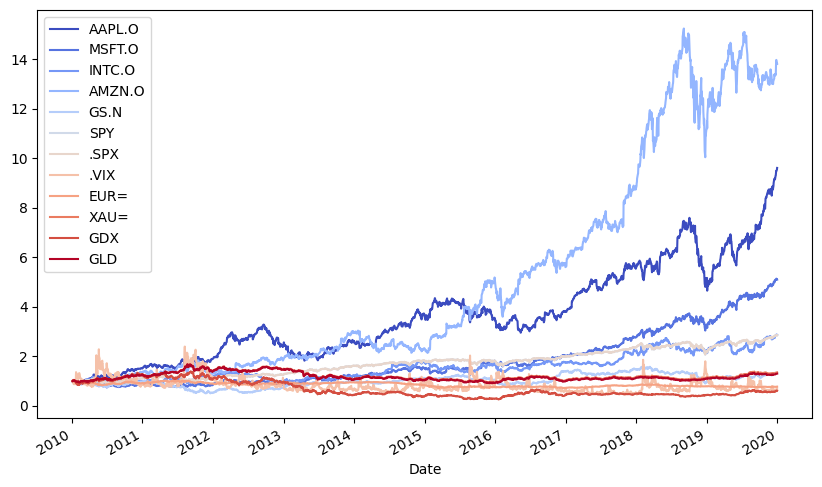

In [3]:
# plots the normalized time series data
(data / data.iloc[0]).plot(figsize=(10, 6), cmap='coolwarm')

In [8]:
# the price data for all financial time series is lagged and stored in DataFrame object

# the number of lags (in trading days)
lags = 7

In [5]:
def add_lags(data, ric, lags):
    cols = []
    df = pd.DataFrame(data[ric])
    for lag in range(1, lags + 1):
        # creates a column name
        col = 'lag_{}'.format(lag)
        # lags the price data
        df[col] = df[ric].shift(lag)
        # adds the column name to a list object
        cols.append(col)
    df.dropna(inplace=True)
    return df, cols

In [9]:
dfs = {}
for sym in data.columns:
    # creates the lagged data for every financial time series
    df, cols = add_lags(data, sym, lags)
    dfs[sym] = df

In [10]:
dfs[sym].head(7)

,GLD,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
Date,,,,,,,,
2010-01-13,111.54,110.49,112.85,111.37,110.82,111.51,109.70,109.80
2010-01-14,112.03,111.54,110.49,112.85,111.37,110.82,111.51,109.70
2010-01-15,110.86,112.03,111.54,110.49,112.85,111.37,110.82,111.51
2010-01-19,111.52,110.86,112.03,111.54,110.49,112.85,111.37,110.82
2010-01-20,108.94,111.52,110.86,112.03,111.54,110.49,112.85,111.37
2010-01-21,107.37,108.94,111.52,110.86,112.03,111.54,110.49,112.85
2010-01-22,107.17,107.37,108.94,111.52,110.86,112.03,111.54,110.49


The OLS regression with lagged price data. The price data that is lagged by only one day gas the highest explanatory power. Its weight is close to 1, supporting the idea that the best predictor for tomorrow's price of a financial instrument is its price today.

In [12]:
## the OLS regression with lagged price data
# the price data that is lagged by only one day gas the highest explanatory power.
regs = {}
for sym in data.columns:
    # gets the data for the current time series
    df = dfs[sym]
    # implements the regression analysis
    reg = np.linalg.lstsq(df[cols], df[sym], rcond=-1)[0]
    # stores the optimal regression parameters in a dict object
    regs[sym] = reg

In [13]:
# combines the optimal results into a single ndarray object
rega = np.stack(tuple(regs.values()))

In [15]:
# puts the results into a DataFrame object and shows them
regd = pd.DataFrame(rega, columns=cols, index=data.columns)

In [16]:
regd

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
AAPL.O,1.010572,-0.059223,0.025791,0.053513,-0.017241,0.006026,-0.018444
MSFT.O,0.892760,0.011245,0.117456,-0.083167,-0.025838,0.056735,0.032256
INTC.O,0.951860,0.057875,0.049000,-0.077168,-0.037288,0.044927,0.011243
AMZN.O,0.979914,-0.013370,0.020554,0.000707,0.052510,-0.045160,0.005589
GS.N,0.980616,0.034161,-0.017218,0.004189,-0.038709,0.058471,-0.021468
SPY,0.969174,0.006678,0.022766,-0.024438,-0.023662,0.037870,0.012073
.SPX,0.967234,0.010588,0.021875,-0.025242,-0.031784,0.051474,0.006321
.VIX,0.882277,0.059139,-0.028948,0.028449,-0.025578,0.051097,0.030567
EUR=,0.985907,0.023882,-0.048428,0.050793,-0.021690,0.014885,-0.005478
XAU=,0.986444,0.006938,0.016628,-0.021549,0.004358,0.019784,-0.012540


<Axes: >

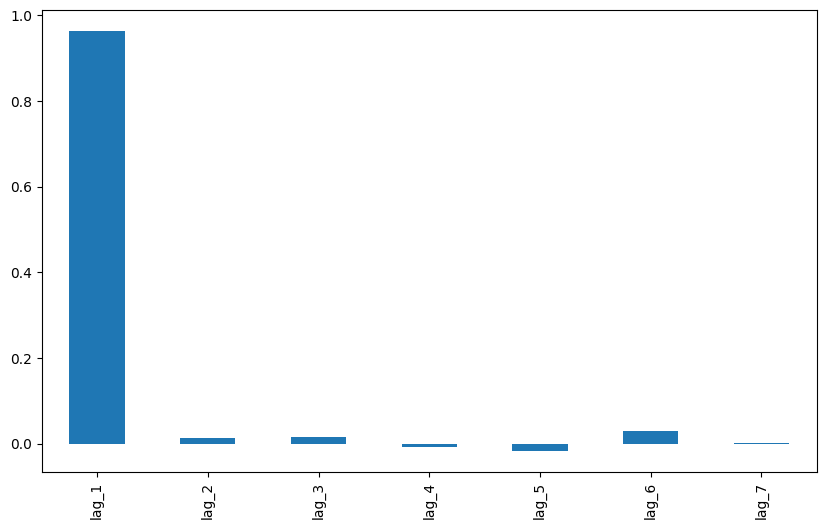

In [17]:
# visualize the average optimal regression parameters (weights) for every lag
regd.mean().plot(kind='bar', figsize=(10, 6))

There seems to be strong supporting evidence for the EMH in its weak form. It is noteworthy that the OLS regression analysis as implemented here vilolates several assumptions. The features are assumed to be noncorrelated among each other.

This explains why only one feature is enough to accomplish the approximation and prediction based on the OLS regression approach. Adding more highly correlated features does not yield any improvements.

Another fundamental assumption violated is the stationarity of the time series data.

In [18]:
# shows the correlation between the lagged time series
dfs[sym].corr()

,GLD,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
GLD,1.000000,0.997249,0.994624,0.991995,0.989327,0.986700,0.984142,0.981525
lag_1,0.997249,1.000000,0.997246,0.994625,0.991997,0.989331,0.986709,0.984154
lag_2,0.994624,0.997246,1.000000,0.997245,0.994623,0.991999,0.989332,0.986712
lag_3,0.991995,0.994625,0.997245,1.000000,0.997245,0.994625,0.992003,0.989338
lag_4,0.989327,0.991997,0.994623,0.997245,1.000000,0.997246,0.994629,0.992009
lag_5,0.986700,0.989331,0.991999,0.994625,0.997246,1.000000,0.997246,0.994631
lag_6,0.984142,0.986709,0.989332,0.992003,0.994629,0.997246,1.000000,0.997247
lag_7,0.981525,0.984154,0.986712,0.989338,0.992009,0.994631,0.997247,1.000000


In [19]:
# test for stationarity using Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

adfuller(data[sym].dropna())

(-1.9488969577009956,
 0.3094193074034716,
 0,
 2515,
 {'1%': -3.4329527780962255,
  '5%': -2.8626898965523724,
  '10%': -2.567382133955709},
 8446.683102944744)

# Market Prediction Based on Returns Data

Some concrete exmamples might shed light on possible answers. The same data is used to derive log returns from the price data. The idea is to compare the performance of OLS regression to the performance of neural networks in predicting the next day's direction of movement for the different time series.

The goal at this stage is to discover statistical inefficiencies as compared to economic inefficiencies. Statistical inefficiencies are given when a model is able to predict the direction of the future price movement with a certain edge. Economic inefficiencies would only be given if the statistics inefficiencies can be exploited profitably throudh a trading strategy that takes into account, for example, transaction costs.

The first step in the analysis is to create data sets with lagged log returns data.

In [20]:
# Derives the log returns from the price data
rets = np.log(data / data.shift(1))

In [21]:
rets.dropna(inplace=True)

In [25]:
dfs = {}
for sym in data:
    # lags the log returns data
    df, col = add_lags(rets, sym, lags)
    # applies Guassian normalization to the features data
    mu, std = df[cols].mean(), df[cols].std()
    df[cols] = (df[cols] - mu) / std
    dfs[sym] = df

In [26]:
dfs.head()

AttributeError: ignored

In [27]:
dfs[sym].head()

,GLD,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
Date,,,,,,,,
2010-01-14,0.004383,0.957016,-2.169168,1.338562,0.495878,-0.643425,1.661323,-0.102756
2010-01-15,-0.010499,0.437942,0.957072,-2.168945,1.338780,0.496562,-0.643624,1.661401
2010-01-19,0.005936,-1.084249,0.438481,0.956179,-2.168991,1.339545,0.495757,-0.643545
2010-01-20,-0.023407,0.596726,-1.082292,0.437772,0.956368,-2.168567,1.338291,0.495834
2010-01-21,-0.014516,-2.404546,0.597117,-1.082458,0.437922,0.957096,-2.167953,1.338369


In [29]:
# test for stationarity of the time series data
adfuller(dfs[sym]['lag_1'])

(-51.56825150582553,
 0.0,
 0,
 2507,
 {'1%': -3.4329610922579095,
  '5%': -2.8626935681060375,
  '10%': -2.567384088736619},
 7017.165474260225)

In [30]:
# shows the correlation data for the features
dfs[sym].corr()

,GLD,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
GLD,1.000000,-0.029691,0.000300,0.012635,-0.002562,-0.005939,0.009852,-0.001343
lag_1,-0.029691,1.000000,-0.030501,0.000814,0.012765,-0.002876,-0.005323,0.009804
lag_2,0.000300,-0.030501,1.000000,-0.031617,0.000320,0.013234,-0.004335,-0.005237
lag_3,0.012635,0.000814,-0.031617,1.000000,-0.031329,-0.000007,0.014115,-0.004387
lag_4,-0.002562,0.012765,0.000320,-0.031329,1.000000,-0.031761,0.000226,0.014067
lag_5,-0.005939,-0.002876,0.013234,-0.000007,-0.031761,1.000000,-0.032289,0.000217
lag_6,0.009852,-0.005323,-0.004335,0.014115,0.000226,-0.032289,1.000000,-0.032351
lag_7,-0.001343,0.009804,-0.005237,-0.004387,0.014067,0.000217,-0.032351,1.000000


In [31]:
# The accuracy with which OLS regression predicts the next day's direction of movement is slightly above 50% with one exeption
from sklearn.metrics import  accuracy_score

In [32]:
%%time
for sym in data:
    df = dfs[sym]
    # the regression step
    reg = np.linalg.lstsq(df[cols], df[sym], rcond=-1)[0]
    # the prediction step
    pred = np.dot(df[cols], reg)
    acc = accuracy_score(np.sign(df[sym]), np.sign(pred))
    print(f'OLS | {sym:10s} | acc={acc:.4f}')

OLS | AAPL.O     | acc=0.5056
OLS | MSFT.O     | acc=0.5088
OLS | INTC.O     | acc=0.5040
OLS | AMZN.O     | acc=0.5048
OLS | GS.N       | acc=0.5080
OLS | SPY        | acc=0.5080
OLS | .SPX       | acc=0.5167
OLS | .VIX       | acc=0.5291
OLS | EUR=       | acc=0.4984
OLS | XAU=       | acc=0.5207
OLS | GDX        | acc=0.5307
OLS | GLD        | acc=0.5072
CPU times: user 63.7 ms, sys: 55.7 ms, total: 119 ms
Wall time: 126 ms


In [33]:
# the same analysus is done again but this time with a neural network from scikit-learn

from sklearn.neural_network import MLPRegressor

In [34]:
%%time
for sym in data.columns:
    df = dfs[sym]
    # model instantiation
    model = MLPRegressor(hidden_layer_sizes=[512],
                         random_state=100, max_iter=1000,
                         early_stopping=True,
                         validation_fraction=0.15,
                         shuffle=False)
    # model fitting
    model.fit(df[cols], df[sym])
    # prediction step
    pred = model.predict(df[cols])
    # accuracy calculation
    acc = accuracy_score(np.sign(df[sym]), np.sign(pred))
    print(f"MLP | {sym:10s} | acc={acc:.4f}")

MLP | AAPL.O     | acc=0.6005
MLP | MSFT.O     | acc=0.5853
MLP | INTC.O     | acc=0.5766
MLP | AMZN.O     | acc=0.5510
MLP | GS.N       | acc=0.6527
MLP | SPY        | acc=0.5419
MLP | .SPX       | acc=0.5399
MLP | .VIX       | acc=0.6579
MLP | EUR=       | acc=0.5642
MLP | XAU=       | acc=0.5522
MLP | GDX        | acc=0.6029
MLP | GLD        | acc=0.5259
CPU times: user 19.2 s, sys: 12.3 s, total: 31.5 s
Wall time: 17.2 s


In [35]:
# The same analysus is done again but this time with a neural network from keras
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential

In [36]:
np.random.seed(100)
tf.random.set_seed(100)

In [39]:
def create_model(problem='regression'):
    model = Sequential()
    model.add(Dense(512, input_dim=len(cols), activation='relu'))
    if problem == 'regression':
        model.add(Dense(1, activation='linear'))
        model.compile(loss='mse', optimizer='adam')
    else:
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [40]:
%%time
for sym in data.columns[:]:
    df = dfs[sym]
    model = create_model()
    model.fit(df[cols], df[sym], epochs=25, verbose=False)
    pred = model.predict(df[cols])
    acc = accuracy_score(np.sign(df[sym]), np.sign(pred))
    print(f'DNN | {sym:10s} | acc={acc:.4f}')

79/79 [==============================] - 0s 1ms/step
DNN | AAPL.O     | acc=0.5993
79/79 [==============================] - 0s 1ms/step
DNN | MSFT.O     | acc=0.5981
79/79 [==============================] - 0s 1ms/step
DNN | INTC.O     | acc=0.6184
79/79 [==============================] - 0s 1ms/step
DNN | AMZN.O     | acc=0.6029
79/79 [==============================] - 0s 1ms/step
DNN | GS.N       | acc=0.6096
79/79 [==============================] - 0s 2ms/step
DNN | SPY        | acc=0.5578
79/79 [==============================] - 0s 1ms/step
DNN | .SPX       | acc=0.5638
79/79 [==============================] - 0s 1ms/step
DNN | .VIX       | acc=0.6208
79/79 [==============================] - 0s 1ms/step
DNN | EUR=       | acc=0.5275
79/79 [==============================] - 0s 1ms/step
DNN | XAU=       | acc=0.5861
79/79 [==============================] - 0s 1ms/step
DNN | GDX        | acc=0.6224
79/79 [==============================] - 0s 1ms/step
DNN | GLD        | acc=0.6136
CPU 

This simple example shows the neural networks can outperform OLS regression significanty in-sample in predictiing the next day's direction of price movements.

How does the picture change when testing for the out-of-sample performance of the two model types?

In [42]:
split = int(len(dfs[sym]) * 0.8)

In [44]:
# Out-of-sample OLS regression shows similar accuracy levels as in-sample.
%%time
for sym in data.columns:
    df = dfs[sym]
    # creates the training data sub-set
    train = df.iloc[:split]
    reg = np.linalg.lstsq(train[cols], train[sym], rcond=-1)[0]
    # creates the test data sub-set
    test = df.iloc[split:]
    pred = np.dot(test[cols], reg)
    acc = accuracy_score(np.sign(test[sym]), np.sign(pred))
    print(f'OLS | {sym:10s} | acc={acc:.4f}')

OLS | AAPL.O     | acc=0.5219
OLS | MSFT.O     | acc=0.4960
OLS | INTC.O     | acc=0.5418
OLS | AMZN.O     | acc=0.4841
OLS | GS.N       | acc=0.4980
OLS | SPY        | acc=0.5020
OLS | .SPX       | acc=0.5120
OLS | .VIX       | acc=0.5458
OLS | EUR=       | acc=0.4482
OLS | XAU=       | acc=0.5299
OLS | GDX        | acc=0.5159
OLS | GLD        | acc=0.5100
CPU times: user 59.5 ms, sys: 55.4 ms, total: 115 ms
Wall time: 82.2 ms


In [46]:
# the performace of the MLPRegressor model is out-of-sample much worse
%%time
for sym in data.columns:
    df = dfs[sym]
    train = df.iloc[:split]
    model = MLPRegressor(hidden_layer_sizes=[512],
                         random_state=100,
                         max_iter=1000,
                         early_stopping=True,
                         validation_fraction=0.15)
    model.fit(train[cols], train[sym])
    test = df.iloc[split:]
    pred = model.predict(test[cols])
    acc = accuracy_score(np.sign(test[sym]), np.sign(pred))
    print(f'MLP | {sym:10s} | acc={acc:.4f}')

MLP | AAPL.O     | acc=0.4861
MLP | MSFT.O     | acc=0.5060
MLP | INTC.O     | acc=0.5299
MLP | AMZN.O     | acc=0.4741
MLP | GS.N       | acc=0.4821
MLP | SPY        | acc=0.5139
MLP | .SPX       | acc=0.5060
MLP | .VIX       | acc=0.5020
MLP | EUR=       | acc=0.5000
MLP | XAU=       | acc=0.5179
MLP | GDX        | acc=0.4900
MLP | GLD        | acc=0.4920
CPU times: user 21.9 s, sys: 14.4 s, total: 36.4 s
Wall time: 20.5 s


In [49]:
# the same holds true for the Sequential model

%%time
for sym in data.columns:
    df = dfs[sym]
    train = df.iloc[:split]
    model = create_model()
    model.fit(train[cols], train[sym], epochs=50, verbose=False)
    test = df.iloc[split:]
    pred = model.predict(test[cols])
    acc = accuracy_score(np.sign(test[sym]), np.sign(pred))
    print(f'DNN | {sym:10s} | acc={acc:.4f}')

16/16 [==============================] - 0s 2ms/step
DNN | AAPL.O     | acc=0.4880
16/16 [==============================] - 0s 1ms/step
DNN | MSFT.O     | acc=0.5319
16/16 [==============================] - 0s 1ms/step
DNN | INTC.O     | acc=0.5000
16/16 [==============================] - 0s 1ms/step
DNN | AMZN.O     | acc=0.4781
16/16 [==============================] - 0s 2ms/step
DNN | GS.N       | acc=0.5100
16/16 [==============================] - 0s 1ms/step
DNN | SPY        | acc=0.5359
16/16 [==============================] - 0s 1ms/step
DNN | .SPX       | acc=0.5279
16/16 [==============================] - 0s 2ms/step
DNN | .VIX       | acc=0.4940
16/16 [==============================] - 0s 1ms/step
DNN | EUR=       | acc=0.5239
16/16 [==============================] - 0s 1ms/step
DNN | XAU=       | acc=0.4841
16/16 [==============================] - 0s 1ms/step
DNN | GDX        | acc=0.4980
16/16 [==============================] - 0s 1ms/step
DNN | GLD        | acc=0.5120
CPU 

Based on the approaches chosen in this section markets seem to be at least efficient in the weak form. Just analyzing historical return patterns based on OLS regression or nueral networks might not be enough to discover statistical inefficiencies.

# Market Prediction with More Features

Technical indicators to generate buy or sell signals can also be used as features for the training of neural networks.

In [51]:
# using an SMA, rolling minimum and maximum values, momentum and rolling volatility

url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'

In [52]:
data = pd.read_csv(url, index_col=0, parse_dates=True).dropna()

In [54]:
def add_lags(data, ric, lags, window=50):
    cols = []
    df = pd.DataFrame(data[ric])
    df.dropna(inplace=True)
    df['r'] = np.log(df / df.shift())
    # simple moving average (SMA)
    df['sma'] = df[ric].rolling(window).mean()
    # rolling minimum
    df['min'] = df[ric].rolling(window).min()
    # rolling maximum
    df['max'] = df[ric].rolling(window).max()
    # momentum as average of log return
    df['mom'] = df['r'].rolling(window).mean()
    # rolling volatility
    df['vol'] = df['r'].rolling(window).std()
    df.dropna(inplace=True)
    # direction as binary feature
    df['d'] = np.where(df['r'] > 0, 1, 0)

    features = [ric, 'r', 'd', 'sma', 'min', 'max', 'mom', 'vol']

    for f in features:
        for lag in range(1, lags + 1):
            col = f'{f}_lag_{lag}'
            df[col] = df[f].shift(lag)
            cols.append(col)

    df.dropna(inplace=True)
    return df, cols

In [55]:
lags = 5

In [57]:
data

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N,SPY,.SPX,.VIX,EUR=,XAU=,GDX,GLD
Date,,,,,,,,,,,,
2010-01-04,30.572827,30.950,20.88,133.90,173.08,113.33,1132.99,20.04,1.4411,1120.0000,47.71,109.80
2010-01-05,30.625684,30.960,20.87,134.69,176.14,113.63,1136.52,19.35,1.4368,1118.6500,48.17,109.70
2010-01-06,30.138541,30.770,20.80,132.25,174.26,113.71,1137.14,19.16,1.4412,1138.5000,49.34,111.51
2010-01-07,30.082827,30.452,20.60,130.00,177.67,114.19,1141.69,19.06,1.4318,1131.9000,49.10,110.82
2010-01-08,30.282827,30.660,20.83,133.52,174.31,114.57,1144.98,18.13,1.4412,1136.1000,49.84,111.37
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,284.270000,157.380,59.41,1789.21,229.91,321.23,3223.38,12.67,1.1087,1498.8100,28.66,141.27
2019-12-26,289.910000,158.670,59.82,1868.77,231.21,322.94,3239.91,12.65,1.1096,1511.2979,29.08,142.38
2019-12-27,289.800000,158.960,60.08,1869.80,230.66,322.86,3240.02,13.43,1.1175,1510.4167,28.87,142.33


In [58]:
for ric in data:
    print(ric)

AAPL.O
MSFT.O
INTC.O
AMZN.O
GS.N
SPY
.SPX
.VIX
EUR=
XAU=
GDX
GLD


In [59]:
dfs = {}
for ric in data:
    df, cols = add_lags(data, ric, lags)
    dfs[ric] = df.dropna(), cols

In-samle, the performance of the `MLPClassifier` model is much better when taking into account the new features and normalizing them for training. The `Sequential` model of `Keras` reaches accuracies of acound 70% for the number of epochs trained.

In [60]:
from sklearn.neural_network import MLPClassifier

In [61]:
%%time
for ric in data:
    model = MLPClassifier(hidden_layer_sizes=[512],
                          random_state=100,
                          max_iter=1000,
                          early_stopping=True,
                          validation_fraction=0.15,
                          shuffle=False)
    df, cols = dfs[ric]
    df[cols] = (df[cols] - df[cols].mean()) / df[cols].std()
    model.fit(df[cols], df['d'])
    pred = model.predict(df[cols])
    acc = accuracy_score(df['d'], pred)

    print(f'IN-SAMPLE | {ric:6s} | acc={acc:.4f}')

IN-SAMPLE | AAPL.O | acc=0.5510
IN-SAMPLE | MSFT.O | acc=0.5376
IN-SAMPLE | INTC.O | acc=0.5607
IN-SAMPLE | AMZN.O | acc=0.5559
IN-SAMPLE | GS.N   | acc=0.5794
IN-SAMPLE | SPY    | acc=0.5729
IN-SAMPLE | .SPX   | acc=0.5941
IN-SAMPLE | .VIX   | acc=0.6940
IN-SAMPLE | EUR=   | acc=0.5766
IN-SAMPLE | XAU=   | acc=0.5672
IN-SAMPLE | GDX    | acc=0.5847
IN-SAMPLE | GLD    | acc=0.5567
CPU times: user 13.1 s, sys: 7.14 s, total: 20.2 s
Wall time: 11.4 s


In [63]:
for ric in data:
    model = create_model('classification')
    df, cols = dfs[ric]
    df[cols] = (df[cols] - df[cols].mean()) / df[cols].std()
    model.fit(df[cols], df['d'], epochs=50, verbose=False)
    pred = np.where(model.predict(df[cols]) > 0.5, 1., 0)
    acc = accuracy_score(df['d'], pred)
    print(f'IN-SAMPLE | {ric:7s} | acc={acc:.4f}')

77/77 [==============================] - 0s 1ms/step
IN-SAMPLE | AAPL.O  | acc=0.6989
77/77 [==============================] - 0s 1ms/step
IN-SAMPLE | MSFT.O  | acc=0.6867
77/77 [==============================] - 0s 1ms/step
IN-SAMPLE | INTC.O  | acc=0.6965
77/77 [==============================] - 0s 1ms/step
IN-SAMPLE | AMZN.O  | acc=0.6709
77/77 [==============================] - 0s 1ms/step
IN-SAMPLE | GS.N    | acc=0.6993
77/77 [==============================] - 0s 1ms/step
IN-SAMPLE | SPY     | acc=0.6896
77/77 [==============================] - 0s 1ms/step
IN-SAMPLE | .SPX    | acc=0.6928
77/77 [==============================] - 0s 1ms/step
IN-SAMPLE | .VIX    | acc=0.7416
77/77 [==============================] - 0s 1ms/step
IN-SAMPLE | EUR=    | acc=0.6875
77/77 [==============================] - 0s 1ms/step
IN-SAMPLE | XAU=    | acc=0.7034
77/77 [==============================] - 0s 1ms/step
IN-SAMPLE | GDX     | acc=0.6916
77/77 [==============================] - 0s 1ms/step
I

Are these improvemnets to be transferred to the out-of-sample prediction accuracies? The numbers do not represent real improvements when compared to the approach, relying only on lagged returns data as features.

In [64]:
def train_test_model(model):
    for ric in data:
        df, cols = dfs[ric]
        split = int(len(df) * 0.85)
        train = df.iloc[:split].copy()
        mu, std = train[cols].mean(), train[cols].std()
        train[cols] = (train[cols] - mu) / std
        model.fit(train[cols], train['d'])
        test = df.iloc[split:].copy()
        test[cols] = (test[cols] - mu) / std
        pred = model.predict(test[cols])
        acc = accuracy_score(test['d'], pred)
        print(f'OUT-OF-SAMPLE | {ric:7s} | acc={acc:.4f}')

In [65]:
model_mlp = MLPClassifier(hidden_layer_sizes=[512],
                          random_state=100,
                          max_iter=1000,
                          early_stopping=True,
                          validation_fraction=0.15,
                          shuffle=False)

In [66]:
%time train_test_model(model_mlp)

OUT-OF-SAMPLE | AAPL.O  | acc=0.4432
OUT-OF-SAMPLE | MSFT.O  | acc=0.4595
OUT-OF-SAMPLE | INTC.O  | acc=0.5000
OUT-OF-SAMPLE | AMZN.O  | acc=0.5270
OUT-OF-SAMPLE | GS.N    | acc=0.4838
OUT-OF-SAMPLE | SPY     | acc=0.4811
OUT-OF-SAMPLE | .SPX    | acc=0.5027
OUT-OF-SAMPLE | .VIX    | acc=0.5676
OUT-OF-SAMPLE | EUR=    | acc=0.4649
OUT-OF-SAMPLE | XAU=    | acc=0.5514
OUT-OF-SAMPLE | GDX     | acc=0.5162
OUT-OF-SAMPLE | GLD     | acc=0.4946
CPU times: user 9.16 s, sys: 4.99 s, total: 14.2 s
Wall time: 7.45 s


The good in-sample performance and the not-so-good out-of-sample performance suggest that overfitting of the neural network might play a crucial role.

One approach to avoid overfitting is to use ensemble methods that combine multiple trained models of the same type to come up with a more robust meta model and better out-of-sample predictions such as bagging. Overall bagging seems to avoid to some extent, overfitting and seems to improve the predictions noticeably.

In [67]:
from sklearn.ensemble import BaggingClassifier

In [68]:
base_estimator = MLPClassifier(hidden_layer_sizes=[256],
                               random_state=100,
                               max_iter=1000, early_stopping=True,
                               validation_fraction=0.15,
                               shuffle=False)

In [73]:
model_bag = BaggingClassifier(estimator=base_estimator,
                              n_estimators=35,   # the number of estimators
                              max_samples=0.25, # maximum percentage of training data used per estimator
                              max_features=0.5, # maximum number of features used per estimator
                              bootstrap=False,  # whether to bootstrap (reuse) data
                              bootstrap_features=True,  # whether to bootstrap (reuse) features
                              n_jobs=8,   # number of parallel jobs
                              random_state=100
                              )

In [74]:
%time train_test_model(model_bag)

OUT-OF-SAMPLE | AAPL.O  | acc=0.5000
OUT-OF-SAMPLE | MSFT.O  | acc=0.5703
OUT-OF-SAMPLE | INTC.O  | acc=0.5054
OUT-OF-SAMPLE | AMZN.O  | acc=0.5270
OUT-OF-SAMPLE | GS.N    | acc=0.5135
OUT-OF-SAMPLE | SPY     | acc=0.5568
OUT-OF-SAMPLE | .SPX    | acc=0.5514
OUT-OF-SAMPLE | .VIX    | acc=0.5432
OUT-OF-SAMPLE | EUR=    | acc=0.5054
OUT-OF-SAMPLE | XAU=    | acc=0.5351
OUT-OF-SAMPLE | GDX     | acc=0.5054
OUT-OF-SAMPLE | GLD     | acc=0.5189
CPU times: user 2.07 s, sys: 325 ms, total: 2.39 s
Wall time: 34.4 s


# Market Prediction intraday

Analyses implemented so far point more in the direction that marekts are weakly efficient on an end-of-day basis. What about intraday markets?

Now dataset contains hourly closing prices. Since trading hours might differ from instrument to instrument, the data set is incomplete.

In [77]:
url = 'http://hilpisch.com/aiif_eikon_id_data.csv'

In [78]:
data = pd.read_csv(url, index_col=0, parse_dates=True)

In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5529 entries, 2019-03-01 00:00:00 to 2020-01-01 00:00:00
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL.O  3384 non-null   float64
 1   MSFT.O  3378 non-null   float64
 2   INTC.O  3275 non-null   float64
 3   AMZN.O  3381 non-null   float64
 4   GS.N    1686 non-null   float64
 5   SPY     3388 non-null   float64
 6   .SPX    1802 non-null   float64
 7   .VIX    2959 non-null   float64
 8   EUR=    5429 non-null   float64
 9   XAU=    5149 non-null   float64
 10  GDX     3173 non-null   float64
 11  GLD     3351 non-null   float64
dtypes: float64(12)
memory usage: 561.5 KB


In [80]:
lags = 5

In [81]:
dfs = {}
for ric in data:
    df, cols = add_lags(data, ric, lags)
    dfs[ric] = df, cols

In [84]:
%time train_test_model(model_mlp)

OUT-OF-SAMPLE | AAPL.O  | acc=0.5420
OUT-OF-SAMPLE | MSFT.O  | acc=0.4930
OUT-OF-SAMPLE | INTC.O  | acc=0.5549
OUT-OF-SAMPLE | AMZN.O  | acc=0.4709
OUT-OF-SAMPLE | GS.N    | acc=0.5184
OUT-OF-SAMPLE | SPY     | acc=0.4860
OUT-OF-SAMPLE | .SPX    | acc=0.5019
OUT-OF-SAMPLE | .VIX    | acc=0.4885
OUT-OF-SAMPLE | EUR=    | acc=0.5130
OUT-OF-SAMPLE | XAU=    | acc=0.4824
OUT-OF-SAMPLE | GDX     | acc=0.4765
OUT-OF-SAMPLE | GLD     | acc=0.5455
CPU times: user 12.5 s, sys: 7.08 s, total: 19.5 s
Wall time: 10.7 s


In [85]:
%time train_test_model(model_bag)

OUT-OF-SAMPLE | AAPL.O  | acc=0.5660
OUT-OF-SAMPLE | MSFT.O  | acc=0.5551
OUT-OF-SAMPLE | INTC.O  | acc=0.5072
OUT-OF-SAMPLE | AMZN.O  | acc=0.4830
OUT-OF-SAMPLE | GS.N    | acc=0.5020
OUT-OF-SAMPLE | SPY     | acc=0.4680
OUT-OF-SAMPLE | .SPX    | acc=0.4677
OUT-OF-SAMPLE | .VIX    | acc=0.5161
OUT-OF-SAMPLE | EUR=    | acc=0.5242
OUT-OF-SAMPLE | XAU=    | acc=0.5229
OUT-OF-SAMPLE | GDX     | acc=0.5107
OUT-OF-SAMPLE | GLD     | acc=0.5475
CPU times: user 2.04 s, sys: 330 ms, total: 2.37 s
Wall time: 38.5 s


The prediction accuracies intrady are again distributed around 50% with a relatively wide spread for the single nueral network.

The bagging meta model shows a more consistent out-of-sample performance with many of the obeserved accuracy values a few percentage points above the 50% benchmark.